# Bibliotecas utilizadas

In [5]:
import numpy as np #trabalha com arrays e matrizes de uma forma otimizada (define constantes uteis)
import matplotlib.pyplot as plt #biblioteca especializada para criar gráficos, e tabelas
import math #define funções matematicas como seno e cosseno
import scipy.signal as signal #biblioteca especializada para o processamento de sinais
from scipy.signal import find_peaks #será utilizado para encontrar picos em uma função

# Funções

In [15]:
def dchirp(TW, p):
  '''
  Gera um sinal chirp amostrado

  uso: s = dchirp (TW, p)

  s: amostras de um sinal chirp digital
    exp(j*(W/T)pi*t^2)    -T/2 <= t < +T/2

  TW: produto de tempo-largura do um sinal chirp
  p: taxa de sobre-amostragem  (fs = pW)
  '''

  alfa = 1/(2*math.pow(p,2)*TW)
  N = round((p*TW))
  n = np.arange(0, N, 1)
  s = np.exp(1j*2*math.pi*alfa*(n - 0.5*N)**2)
  return s

def match_filter(TW, p):
  '''
  Gera um match_filter amostrado

  uso: h = match_filter (TW, p)

  s: amostras de um sinal match_filter digital
    exp(-j*(W/T)pi*t^2)    -T/2 <= t < +T/2

  TW: produto de tempo-largura de um sinal
  p: taxa de sobre-amostragem  (fs = pW)
  '''

  alfa = 1/(2*math.pow(p,2)*TW)
  N = round((p*TW))
  n = np.arange(0, N, 1)
  h = np.exp(-1j*2*math.pi*alfa*(n - 0.5*N)**2)
  return h

def adicionar_ruido_awgn(sinal, snr_db):
    """
    Adiciona ruído branco gaussiano complexo a um sinal complexo para atingir uma SNR específica.
    1)SNR é definido em decibéis (dB).
    2)SNR é a relação entre a potência do sinal e a potência do ruído.
    3)O ruido em sinais complexos é dividido entre a parte real e imaginaria


    Parâmetros:
    sinal : ndarray
        Sinal de entrada (complexo).
    snr_db : float
        Relação sinal-ruído desejada em decibéis (dB).

    Retorna:
    sinal_ruidoso : ndarray
        Sinal com ruído adicionado.
    """
    # Calcula a potência do sinal
    potencia_sinal = np.mean(np.abs(sinal)**2)

    # Converte SNR de dB para escala linear
    snr_linear = 10**(snr_db / 10)

    # Calcula a potência do ruído necessária
    potencia_ruido = potencia_sinal / snr_linear

    # Gera ruído branco gaussiano complexo
    ruido_real = np.random.normal(0, np.sqrt(potencia_ruido / 2), size=sinal.shape)
    ruido_imag = np.random.normal(0, np.sqrt(potencia_ruido / 2), size=sinal.shape)
    ruido = ruido_real + 1j * ruido_imag

    # Adiciona o ruído ao sinal original
    sinal_ruidoso = sinal + ruido

    return sinal_ruidoso

def pkpicker(y):
  '''
  Recebe uma função y e retorna os picos encontrados, utilizando um treshold
  de 40% do valor máximo da função. Ou seja picos com amplitude menor que 40%
  do valor máximo da função serão desconsiderados. Seria um filtro para picos falsos!

  '''
  threshold = np.max(np.abs(y)) * 0.4
  peaks, _ = find_peaks(np.abs(y))
  true_peaks = [peak for peak in peaks if np.abs(y[peak]) > threshold]
  return true_peaks

def atrasa_sinal(s, fs, t_atraso):
    '''
    Atrasa um sinal criando uma "linha do tempo" maior.
    '''
    n_atraso = round(t_atraso * fs)

    tamanho_novo = len(s) + n_atraso
    s_atrasado = np.zeros(tamanho_novo, dtype=s.dtype)

    s_atrasado[n_atraso:] = s

    return s_atrasado

def find_Tds_interpolacao_corrigido(y, fs, N):

    '''
    y sinal de saida do filtro casado
    fs taxa de amostragem
    N quantidade de amostras do filtro casado

    Realiza a identificação dos picos de maneira mais precisa, através da interpolação
    do pico com as 3 amostras mais próximas, criando uma parábola.
    '''

    # velocidade da luz
    c = 3e8

    picos_int = pkpicker(y)
    ponto_referencia_zero = N - 1

    distancias_finais = []

    for n in picos_int:
        # Garante que há vizinhos
        if n <= 0 or n >= len(y) - 1:
            continue

        y_m1 = np.abs(y[n - 1])
        y_0  = np.abs(y[n])
        y_p1 = np.abs(y[n + 1])

        a = (y_p1 + y_m1 - 2 * y_0) / 2
        b = (y_p1 - y_m1) / 2

        if a == 0:
            x_vertex = 0
        else:
            x_vertex = -b / (2 * a)

        n_interp = n + x_vertex


        atraso_seg = (n_interp - ponto_referencia_zero) / fs

        d = (c * atraso_seg) / 2
        distancias_finais.append(d)

    return distancias_finais


def distancia_segundos(distancia):
  '''
  Função que recebe a distância em metros e retorna o tempo de atraso em segundosm util para gerar sinais artificiais
  '''
  c = 3*10**8
  segundos = (2*distancia)/c
  return segundos

def pico_idx_distancie(indicies_picos,fs):
  '''
  recebe o indice dos picos e retorna a distancia em metros
  '''
  #converte para segundos
  indice_segundos = []
  distancias = []
  for indice in indicies_picos:
    indice_segundos.append(indice/fs)
  #calcula distancia
  c = 3*10**8
  for indice in indice_segundos:
    distancia.append((c*indice)/2)
  return distancias


def plot_fft_chirp(TW, p, fs):
    '''
    plota a fft do chirp
    '''
    s = dchirp(TW, p)
    N = len(s)
    freq = np.fft.fftshift(np.fft.fftfreq(N, d=1/(fs)))
    s_fft = np.fft.fftshift(np.abs(np.fft.fft(s)))

    plt.figure(figsize=(20, 5))
    plt.axvline(x=-W/2, color='r', linestyle='--')
    plt.axvline(x=W/2, color='r', linestyle='--')
    plt.plot(freq, s_fft)
    plt.title('Transformada de Fourier do Chirp Amostrado')
    plt.xlabel('Frequência (Hz)')
    plt.ylabel('Magnitude')
    plt.legend(['-W/2', 'W/2', 'Chirp'])
    plt.grid(True)
    plt.show()

# Sinal Chirp Real e Imaginario

/tmp/ipython-input-9-3949581711.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


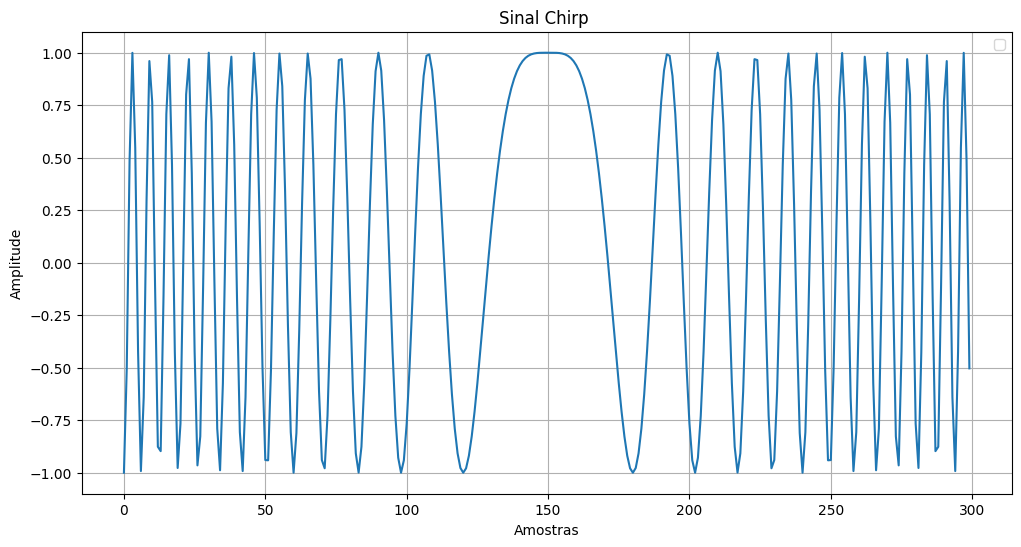

/tmp/ipython-input-9-3949581711.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


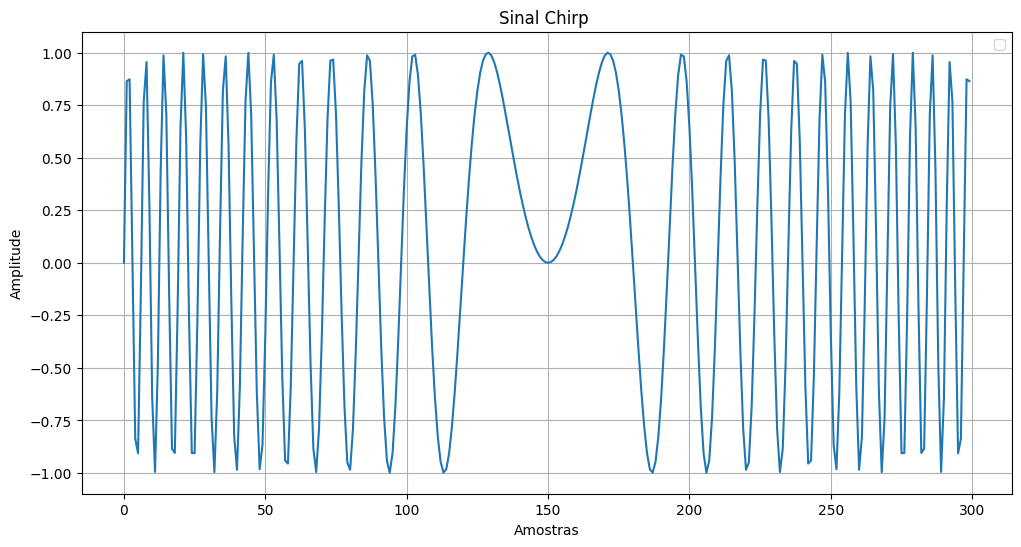

In [9]:
W = 50e6
T = 2e-6
TW = W * T  # TW = 100
p = 3
fs = p * W  # fs = 150 MHz

SinalChirp = dchirp(TW, p)

plt.figure(figsize=(12, 6))
plt.plot(np.real(SinalChirp))
plt.title('Sinal Chirp real')
plt.xlabel('Amostras')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(np.imag(SinalChirp))
plt.title('Sinal Chirp imaginario')
plt.xlabel('Amostras')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()


# Filtro casado real e imaginario

/tmp/ipython-input-10-3198998174.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


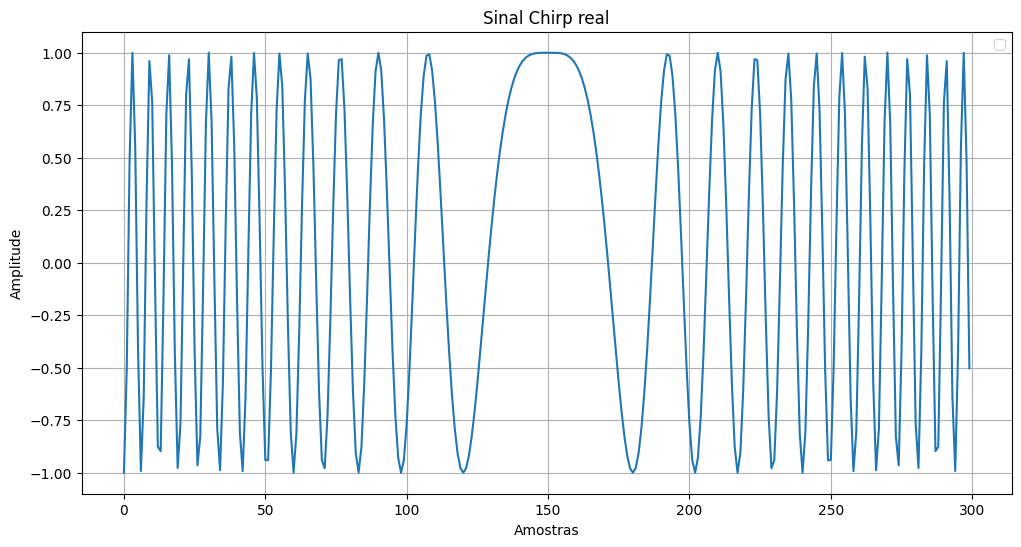

/tmp/ipython-input-10-3198998174.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


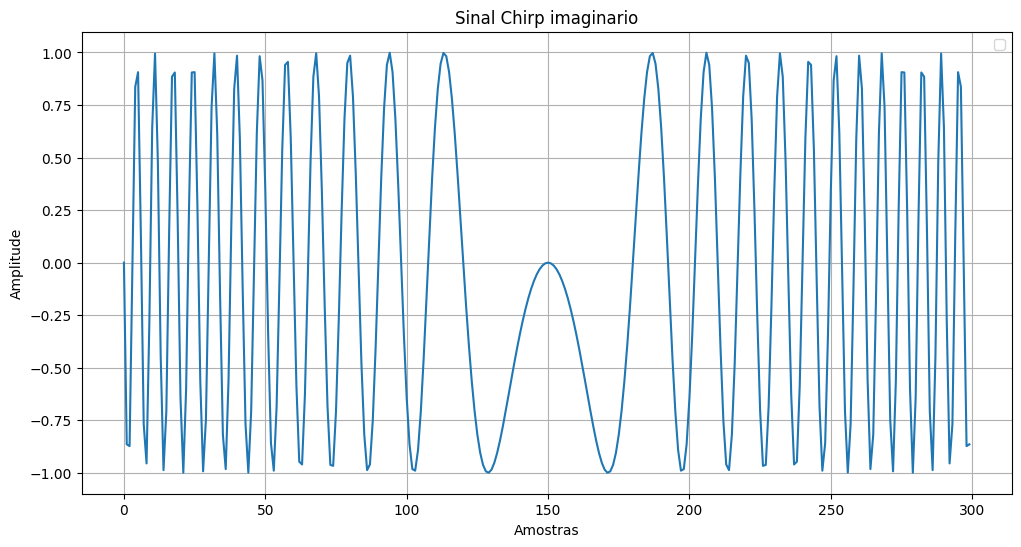

In [10]:
W = 50e6
T = 2e-6
TW = W * T  # TW = 100
p = 3
fs = p * W  # fs = 150 MHz

filtro_casado = match_filter(TW, p)

plt.figure(figsize=(12, 6))
plt.plot(np.real(filtro_casado))
plt.title('Sinal Chirp real')
plt.xlabel('Amostras')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(np.imag(filtro_casado))
plt.title('Sinal Chirp imaginario')
plt.xlabel('Amostras')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()


## FFT DO CHIRP

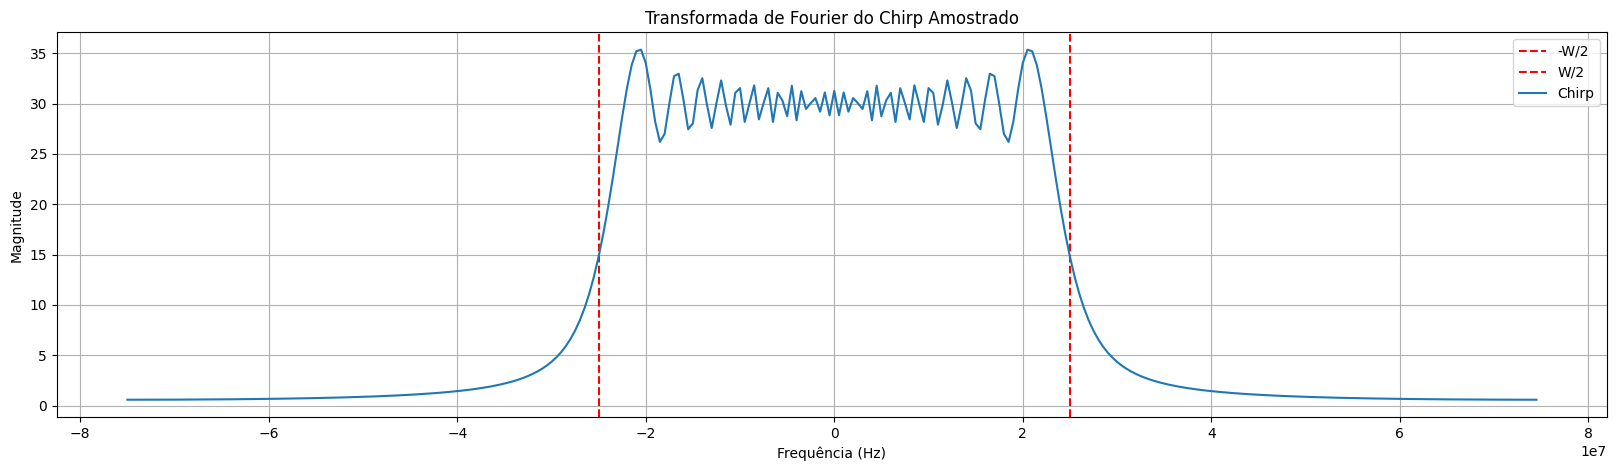

In [16]:
W = 50e6
T = 2e-6
TW = W * T  # TW = 100
p = 3
fs = p * W  # fs = 150 MHz

plot_fft_chirp(TW, p, fs)

## Sinal Chirp Amostrado

/tmp/ipython-input-62-3277840107.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


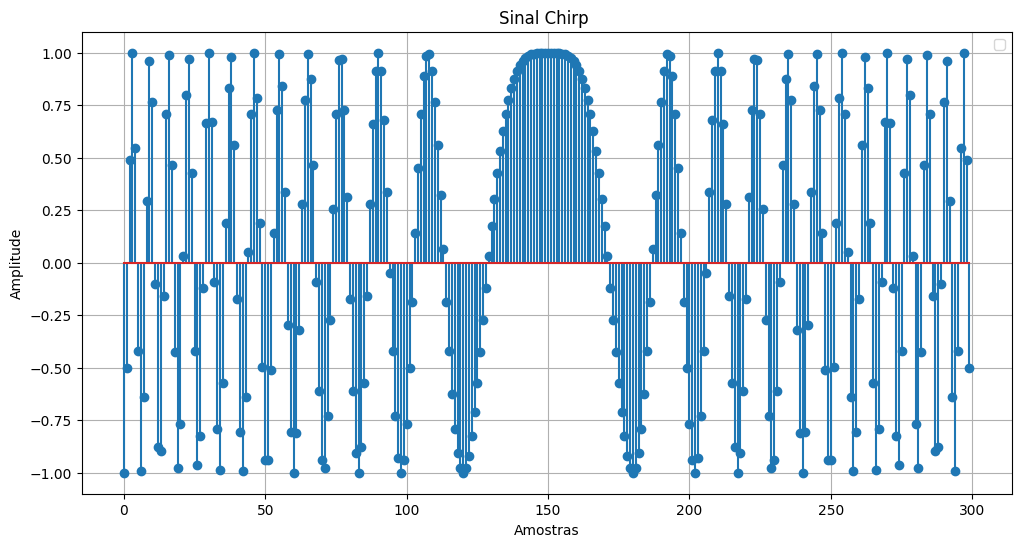

In [ ]:
# --- Parâmetros ---
W = 50e6
T = 2e-6
TW = W * T  # TW = 100
p = 3
fs = p * W  # fs = 150 MHz

SinalChirp = dchirp(TW, p)

plt.figure(figsize=(12, 6))
plt.stem(np.real(SinalChirp))
plt.title('Sinal Chirp ')
plt.xlabel('Amostras')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

## Sinal Chirp com Delay

/tmp/ipython-input-63-4126182779.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


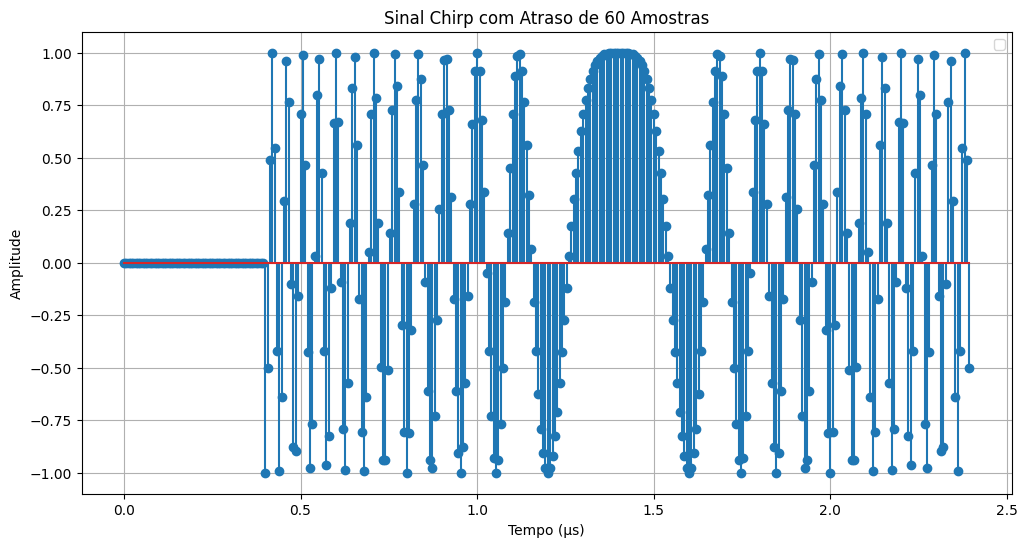

In [ ]:
# --- Parâmetros ---
W = 50e6
T = 2e-6
TW = W * T  # TW = 100
p = 3
fs = p * W  # fs = 150 MHz

# --- Geração do Sinal ---
s_original = dchirp(TW, p)
N = len(s_original) # N = 300 amostras

# Atraso de 60 amostras
atraso_em_segundos = 60 / fs

# Usa função para atrasar o sinal
s_atrasado_correto = atrasa_sinal(s_original, fs, atraso_em_segundos)


tempo_eixo = np.arange(len(s_atrasado_correto)) / fs
plt.figure(figsize=(12, 6))
plt.stem(tempo_eixo * 1e6, np.real(s_atrasado_correto))
plt.title('Sinal Chirp com Atraso de 60 Amostras')
plt.xlabel('Tempo (µs)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

#Plot saida y[n]

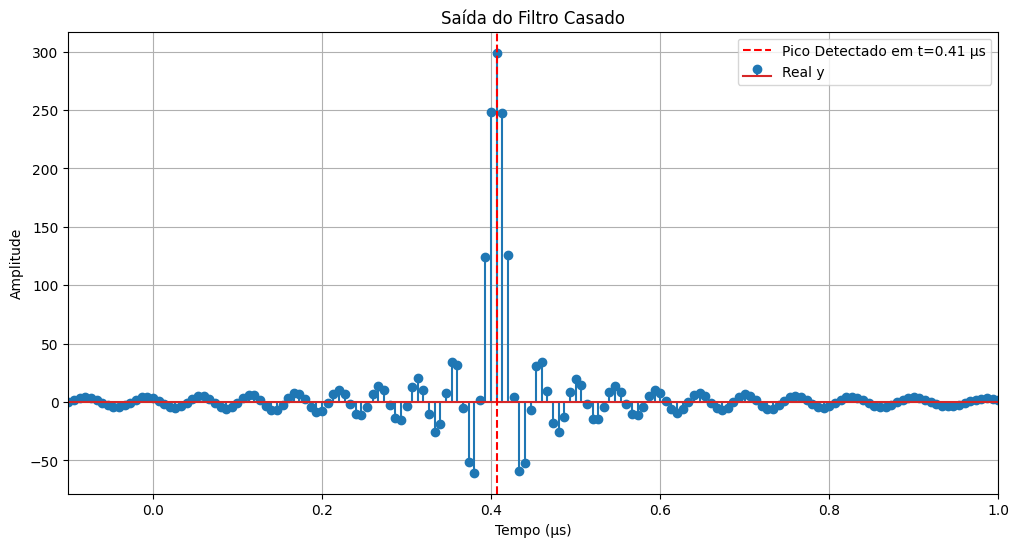

In [ ]:
# --- Parâmetros ---
W = 50e6
T = 2e-6
TW = W * T
p = 3
fs = p * W

#Geração do Sinal
s_original = dchirp(TW, p)
h = match_filter(TW, p)

N = len(s_original)

# Atraso de 60 amostras
atraso_em_segundos = 60 / fs
s_atrasado_correto = atrasa_sinal(s_original, fs, atraso_em_segundos)

# Convolução com o filtro casado
y = np.convolve(s_atrasado_correto, h, mode='full')
indice_pico = np.argmax(np.abs(y))

# Define o ponto de referência (o pico de um eco sem atraso), ponto zero
ponto_referencia_zero = N - 1

# Cria o eixo de tempo em segundos, relativo a essa referência, ja faz o offset, fica mais facil de converter amostras para segundos
eixo_tempo_segundos = (np.arange(len(y)) - ponto_referencia_zero) / fs

# Encontra o tempo exato do pico medido
tempo_pico_medido_s = eixo_tempo_segundos[indice_pico]


plt.figure(figsize=(12, 6))
plt.stem(eixo_tempo_segundos * 1e6, np.real(y), label='Real y')
plt.axvline(x=tempo_pico_medido_s * 1e6, color='r', linestyle='--',
            label=f'Pico Detectado em t={tempo_pico_medido_s * 1e6:.2f} µs')
plt.title('Saída do Filtro Casado')
plt.xlabel('Tempo (µs)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

#Zoom
plt.xlim(-0.1, 1)
plt.show()

In [ ]:
c = 3*10**8

In [ ]:
#Distancia do alvo
R = (c*tempo_pico_medido_s)/2
R

np.float64(61.0)

# SNR

/tmp/ipython-input-67-881825106.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


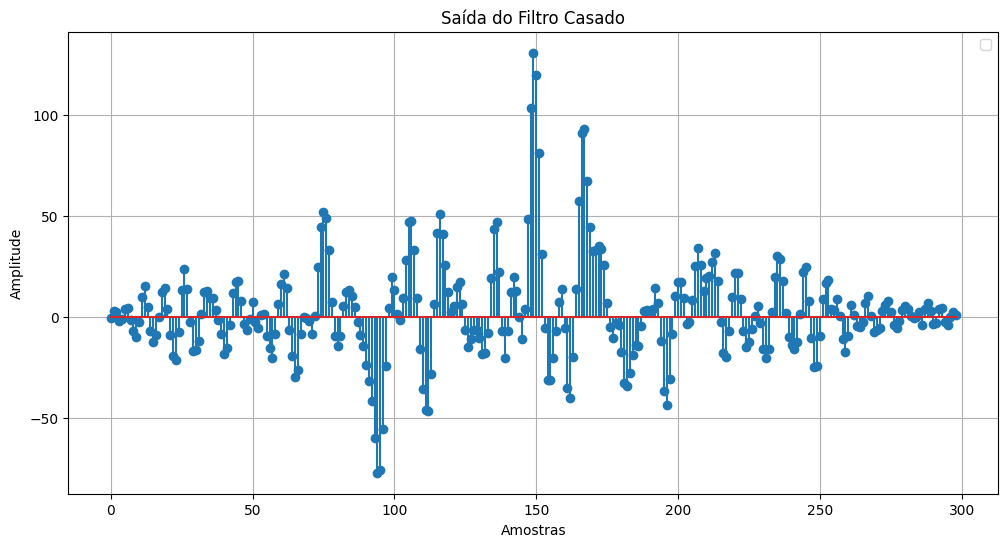

Ganho de processamento: 25.11 dB
Ganho esperado: 21.760912590556813 dB


In [ ]:
# --- Parâmetros ---
W = 50e6
T = 1e-6
TW = W * T  # TW = 100
p = 3
fs = p * W  # fs = 150 MHz

SinalChirp = dchirp(TW, p)
filtroMath = match_filter(TW, p)

Chirp_ruidoso = adicionar_ruido_awgn(SinalChirp, -10)
y = np.convolve(Chirp_ruidoso, filtroMath, mode='full')

plt.figure(figsize=(12, 6))
plt.stem(np.real(y))
plt.title('Saída do Filtro Casado')
plt.xlabel('Amostras')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

#ganho de processamento

input_snr_db = -10
# Estimação do piso de ruído (fora do pico)
noise_floor = np.mean(np.abs(y))
noise_power = noise_floor**2
# Potência do pico do filtro casado
peak_power = np.max(np.abs(y))**2
# Cálculo da SNR de saída em dB
output_snr_db = 10 * np.log10(peak_power / noise_power)
# Ganho de processamento
ganho_esperado = 10*np.log10(TW*p)
processing_gain_db = output_snr_db - input_snr_db
print(f"Ganho de processamento: {processing_gain_db:.2f} dB")
print(f"Ganho esperado: {ganho_esperado} dB")

# Simulação da distância (3 alvos)

---



## Plot dos 3 sinais separados

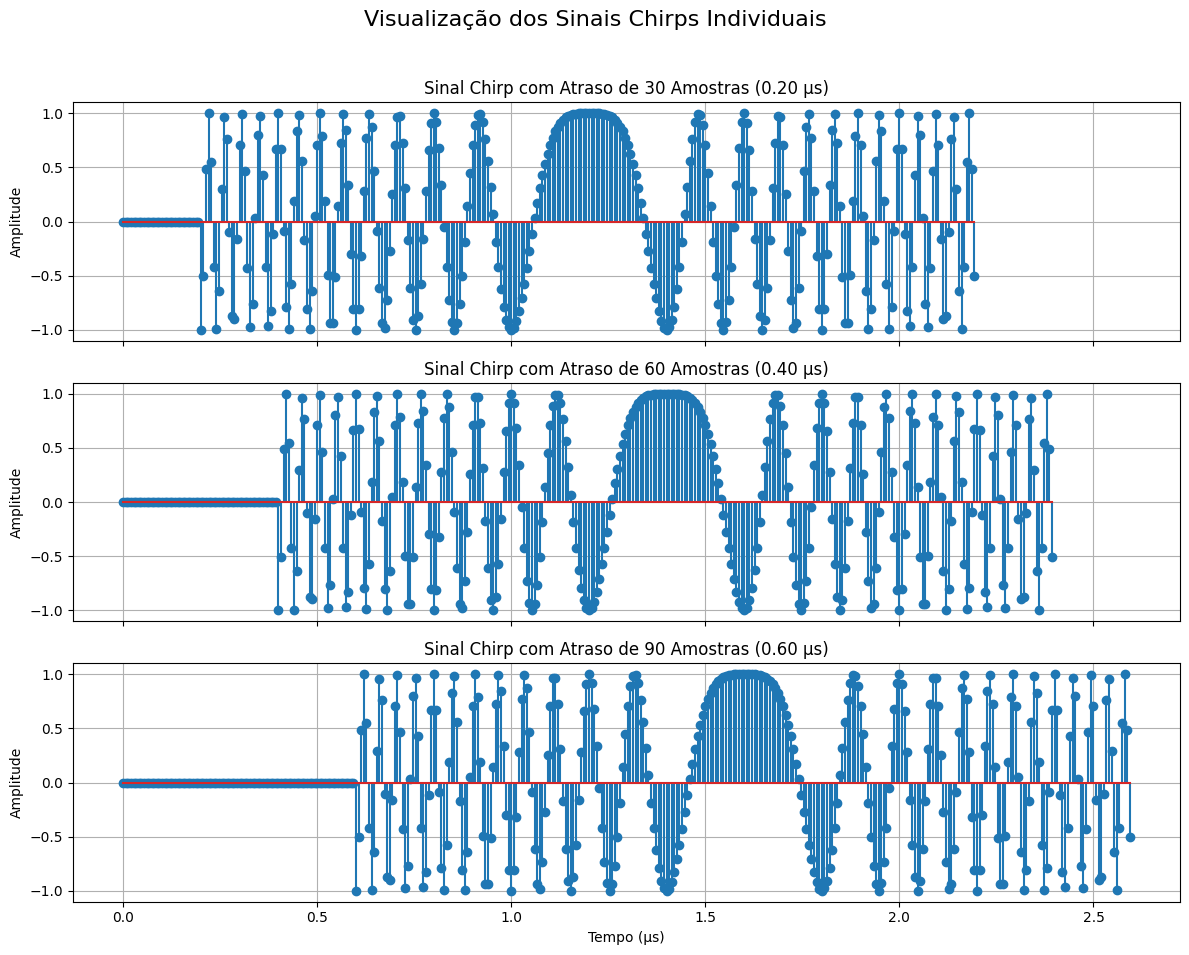

In [ ]:
W = 50e6
T = 2e-6
TW = W * T
p = 3
fs = p * W  # fs = 150 MHz


s_original = dchirp(TW, p)


# Atrasos para cada alvo
atrasos_em_segundos = [30/fs, 60/fs, 90/fs]
atrasos_em_amostras = [30, 60, 90]

# Lista com cada sinal de eco
sinais_atrasados = [atrasa_sinal(s_original, fs, t) for t in atrasos_em_segundos]

fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
fig.suptitle('Visualização dos Sinais Chirps Individuais', fontsize=16)

for i in range(len(sinais_atrasados)):
    s_atrasado = sinais_atrasados[i]
    n_atraso = atrasos_em_amostras[i]
    tempo_eixo = np.arange(len(s_atrasado)) / fs
    axs[i].stem(tempo_eixo * 1e6, np.real(s_atrasado))
    axs[i].set_title(f'Sinal Chirp com Atraso de {n_atraso} Amostras ({atrasos_em_segundos[i]*1e6:.2f} µs)')
    axs[i].set_ylabel('Amplitude')
    axs[i].grid(True)

axs[-1].set_xlabel('Tempo (µs)')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

# 3 Sinais Chirps somados em 1

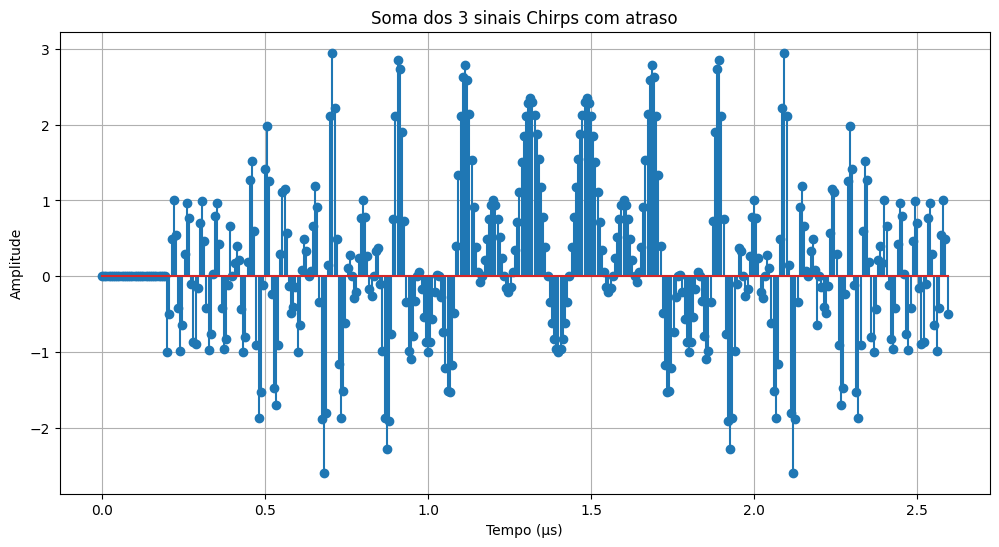

In [ ]:
# --- Parâmetros ---
W = 50e6
T = 2e-6
TW = W * T
p = 3
fs = p * W  # fs = 150 MHz

s_original = dchirp(TW, p)
N = len(s_original)

atrasos_em_segundos = [30/fs, 60/fs, 90/fs]

# Encontra o atraso máximo para definir o tamanho da linha do tempo, a linha deve acomodar todos os sinais, então é preciso utilizar o maior atraso
atraso_max_amostras = round(max(atrasos_em_segundos) * fs)
tamanho_total = N + atraso_max_amostras

# Cria a linha do tempo final, inicialmente com zeros, cria um vetor nulo
sinal_recebido = np.zeros(tamanho_total, dtype=np.complex128)

# Loop para adicionar cada eco na linha do tempo (Insere cada sinal Chirp na posição cerrta no vetor nulo)
for t_atraso in atrasos_em_segundos:
    n_atraso = round(t_atraso * fs)
    start = n_atraso
    end = start + N
    if end <= tamanho_total:#insere o sinal
        sinal_recebido[start:end] += s_original

tempo_eixo = np.arange(len(sinal_recebido)) / fs

plt.figure(figsize=(12, 6))
plt.stem(tempo_eixo * 1e6, np.real(sinal_recebido))
plt.title('Soma dos 3 sinais Chirps com atraso')
plt.xlabel('Tempo (µs)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

## Inserção de Ruido Gaussiano

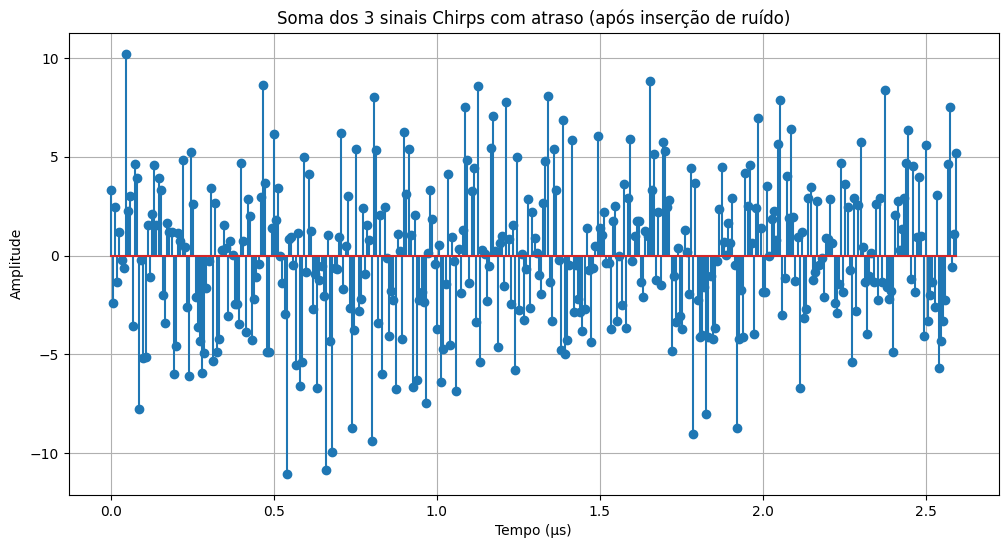

In [ ]:
sinal_recebido = adicionar_ruido_awgn(sinal_recebido, -10) #-10db

tempo_eixo = np.arange(len(sinal_recebido)) / fs
plt.figure(figsize=(12, 6))
plt.stem(tempo_eixo * 1e6, np.real(sinal_recebido))
plt.title('Soma dos 3 sinais Chirps com atraso (após inserção de ruído)')
plt.xlabel('Tempo (µs)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

## Saída do filtro casado

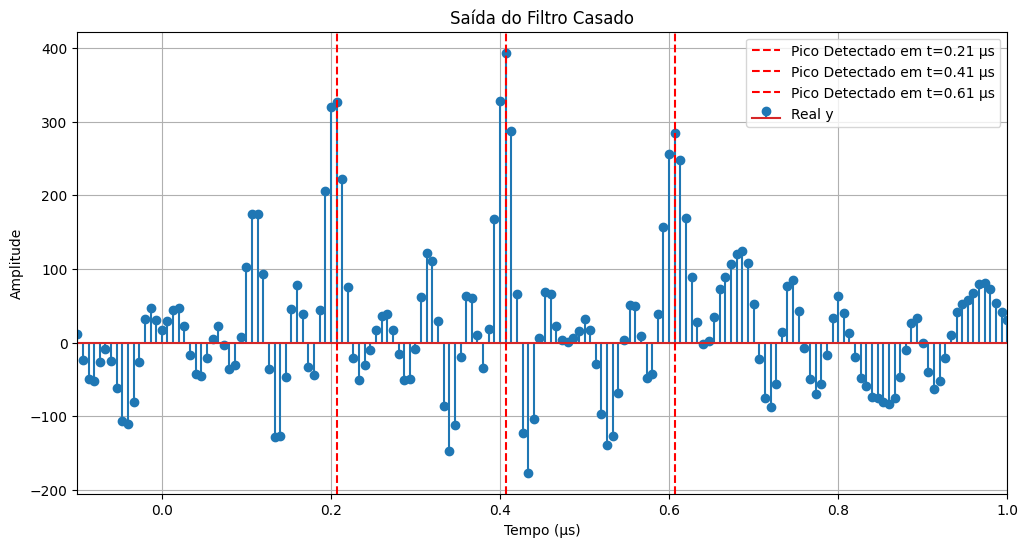

In [ ]:
y = np.convolve(sinal_recebido, h, mode='full')
indice_picos = pkpicker(y)

ponto_referencia_zero = N - 1

eixo_tempo_segundos = (np.arange(len(y)) - ponto_referencia_zero) / fs

#Converte indice para segundos
for indicies in indice_picos:
  tempo_pico_medido_s = eixo_tempo_segundos[indicies]

#Plot
plt.figure(figsize=(12, 6))
plt.stem(eixo_tempo_segundos * 1e6, np.real(y), label='Real y')
for pico in indice_picos:
  plt.axvline(x=eixo_tempo_segundos[pico] * 1e6, color='r', linestyle='--',
              label=f'Pico Detectado em t={eixo_tempo_segundos[pico] * 1e6:.2f} µs')
plt.title('Saída do Filtro Casado')
plt.xlabel('Tempo (µs)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

plt.xlim(-0.1, 1)

plt.show()

## Tabela com os resultados

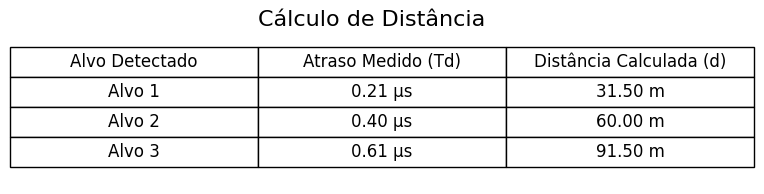

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


tempos_de_atraso_medidos = [0.21e-6,0.40e-6,0.61e-6]

c = 3e8

# Lista para guardar as linhas da nossa tabela
dados_para_tabela = []

for i, td in enumerate(tempos_de_atraso_medidos):

    distancia = (c * td) / 2

    alvo_id = f"Alvo {i+1}" #usa o indice para descrever a numeracao do alvo
    td_str = f"{td * 1e6:.2f} µs"      #converte para us e da a string
    distancia_str = f"{distancia:.2f} m"  #converte para m e da a string
    dados_para_tabela.append([alvo_id, td_str, distancia_str]) #coloca na lista, que na verdade vira uma matriz

colunas = ["Alvo Detectado", "Atraso Medido (Td)", "Distância Calculada (d)"]

fig_tabela, ax_tabela = plt.subplots(figsize=(8, 2))
ax_tabela.axis('tight')
ax_tabela.axis('off')

tabela = ax_tabela.table(cellText=dados_para_tabela,
                        colLabels=colunas,
                        loc='center',
                        cellLoc='center')

tabela.auto_set_font_size(False)
tabela.set_fontsize(12)
tabela.scale(1.2, 1.8)

fig_tabela.suptitle("Cálculo de Distância", fontsize=16)
plt.show()

# Detecção Velocidade

#Sinal Burst

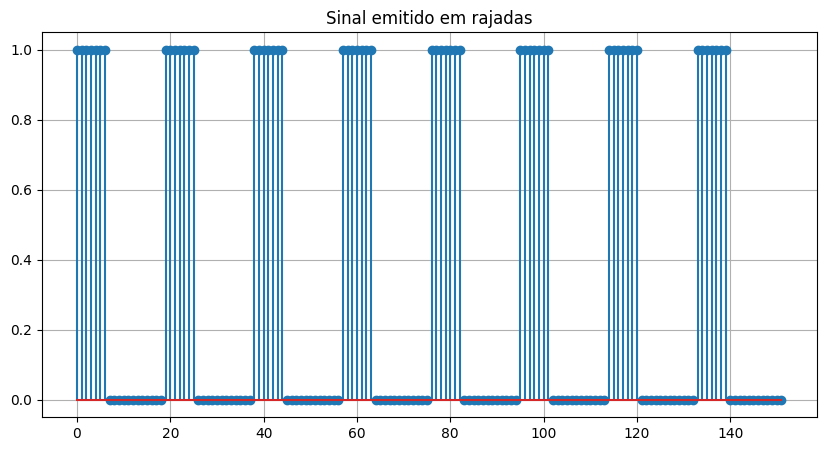

In [ ]:
#com shifit
#sn é multiplicado por e^(-jwdn)

import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftshift

# Parametros
L = 8       # Numero de pulsos
N = 7       # Largura do pulso em amostras
M = 19      # Periodo entre os pulsos

# função boxcar de tamanho N
p = np.ones(N)

# gera o sinal Burst
s = np.zeros(L * M)  # tamanho total do vetor, vetor vazio

for l in range(L):
    start = l * M
    end = start + N
    if end <= len(s):  # insere o sinal no vetor vazio
        s[start:end] += p


plt.figure(figsize=(10, 5))
plt.stem(s)
plt.title("Sinal emitido em rajadas")
plt.grid(True)
plt.show()

## Espectro Sinal Burst

/tmp/ipython-input-74-3464511515.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


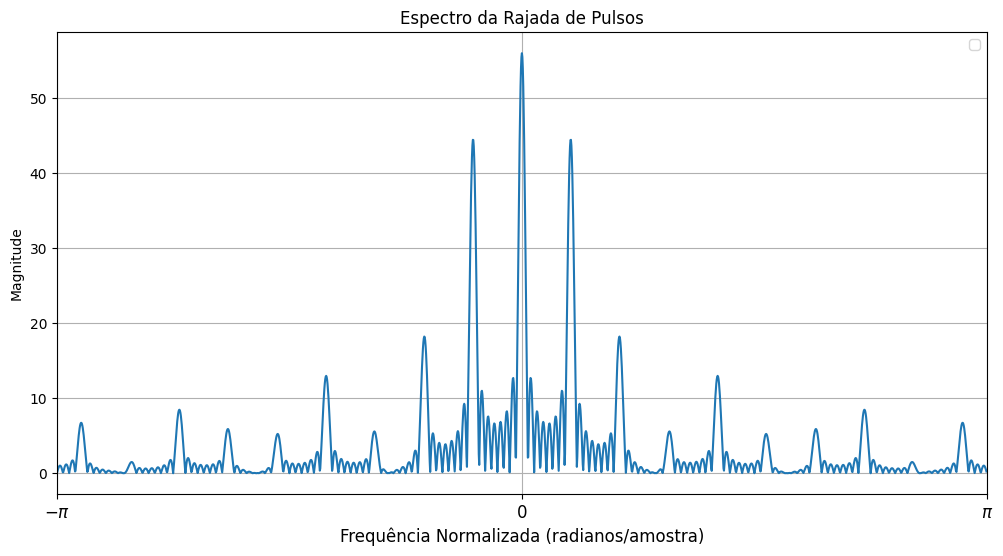

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftshift


L = 8
N = 7
M = 19
wd_real = 0 #alvo sem velocidade

p = np.ones(N)
s = np.zeros(L * M, dtype=np.complex128)
for l in range(L):
    start = l * M
    end = start + N
    if end <= len(s):
        s[start:end] = p

# Aplica o deslocamento doppler
s = s * np.exp(1j * wd_real * np.arange(len(s)))

#fft com zero padding de 2048 para ficar um plot bonito
S = fft(s, 2048)
S_mag = np.abs(S)
S_mag = fftshift(S_mag)


#eixo de frequência em radianos/amostra
freq_rad = np.linspace(-np.pi, np.pi, len(S_mag), endpoint=False)

# Encontra o índice do pico de maior magnitude
indice_pico = np.argmax(S_mag)

# Encontra a frequência do pico (wd medido)
wd_medido = freq_rad[indice_pico]


plt.figure(figsize=(12, 6))
plt.plot(freq_rad, S_mag)
plt.title("Espectro da Rajada de Pulsos")
plt.ylabel("Magnitude")
plt.grid(True)
tick_locations = [-np.pi, 0, np.pi]
tick_labels = ['$-\pi$', '0', '$\pi$']
plt.xticks(tick_locations, tick_labels, fontsize=12)
plt.xlabel("Frequência Normalizada (radianos/amostra)", fontsize=12)
plt.legend()
plt.xlim(-np.pi, np.pi)
plt.show()

#Simulação da detecção da velocidade de um objeto

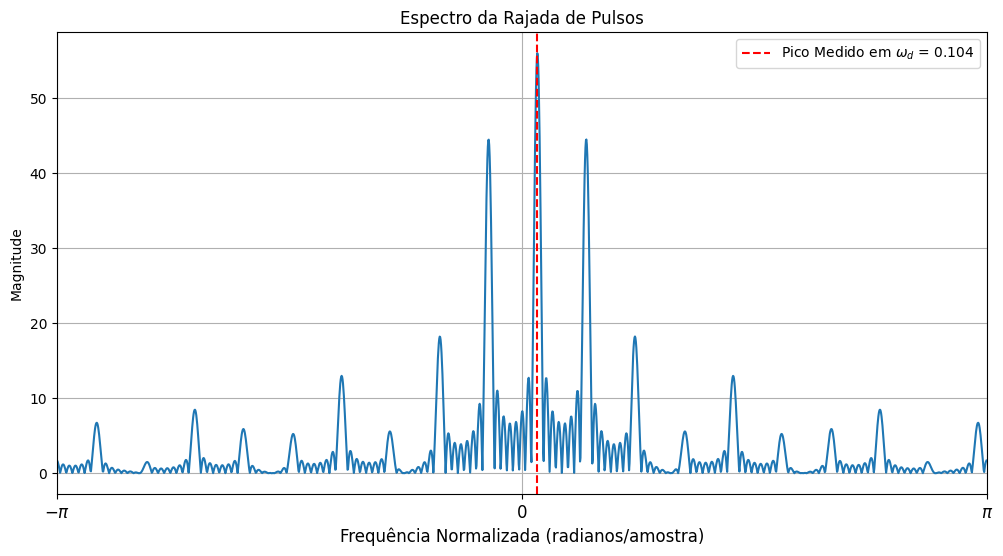

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftshift


L = 8
N = 7
M = 19
wd_real = 2*np.pi/60 # Alvo com velocidade!!!


p = np.ones(N)
s = np.zeros(L * M, dtype=np.complex128)
for l in range(L):
    start = l * M
    end = start + N
    if end <= len(s):
        s[start:end] = p

# Aplica o shift Doppler
s = s * np.exp(1j * wd_real * np.arange(len(s)))

S = fft(s, 2048)
S_mag = np.abs(S)
S_mag = fftshift(S_mag)


freq_rad = np.linspace(-np.pi, np.pi, len(S_mag), endpoint=False)
indice_pico = np.argmax(S_mag)
wd_medido = freq_rad[indice_pico]

plt.figure(figsize=(12, 6))
plt.plot(freq_rad, S_mag)
plt.title("Espectro da Rajada de Pulsos")
plt.ylabel("Magnitude")
plt.grid(True)
tick_locations = [-np.pi, 0, np.pi]
tick_labels = ['$-\pi$', '0', '$\pi$']
plt.xticks(tick_locations, tick_labels, fontsize=12)
plt.xlabel("Frequência Normalizada (radianos/amostra)", fontsize=12)
plt.axvline(wd_medido, color='r', linestyle='--', label=f'Pico Medido em $\omega_d$ = {wd_medido:.3f}')
plt.legend()
plt.xlim(-np.pi, np.pi)
plt.show()

## Otimização sub-amostragem

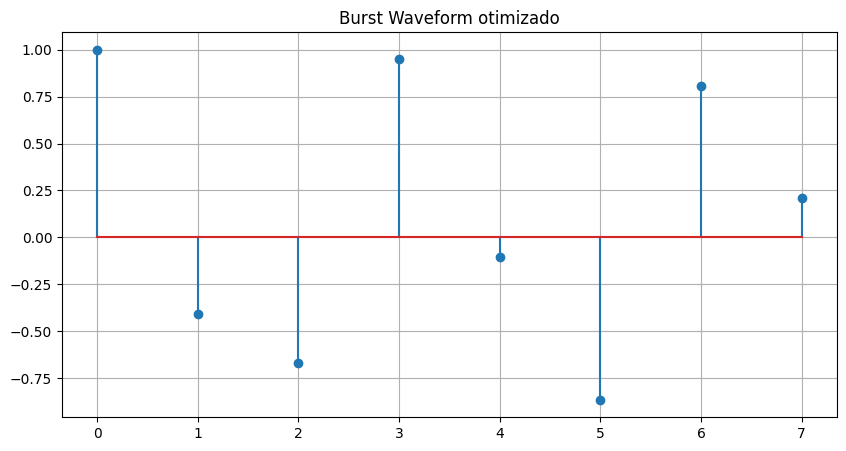

In [ ]:
L = 8
N = 7
M = 19
wd_real = 2*np.pi/60


p = np.ones(N)
s_burst = np.zeros(L * M, dtype=np.complex128)
for l in range(L):
    start = l * M
    end = start + N
    if end <= len(s_burst):
        s_burst[start:end] = p



s_doppler = s_burst * np.exp(1j * wd_real * np.arange(len(s_burst)))

#processo de subamostragem, capturar uma amostra a cada periodo M
y_otimizado = np.zeros(L, dtype=np.complex128)
for i in range(L):
    y_otimizado[i] = s_doppler[i * M]

plt.figure(figsize=(10, 5))
plt.stem(np.real(y_otimizado))
plt.title("Burst Waveform otimizado")
plt.grid(True)
plt.show()

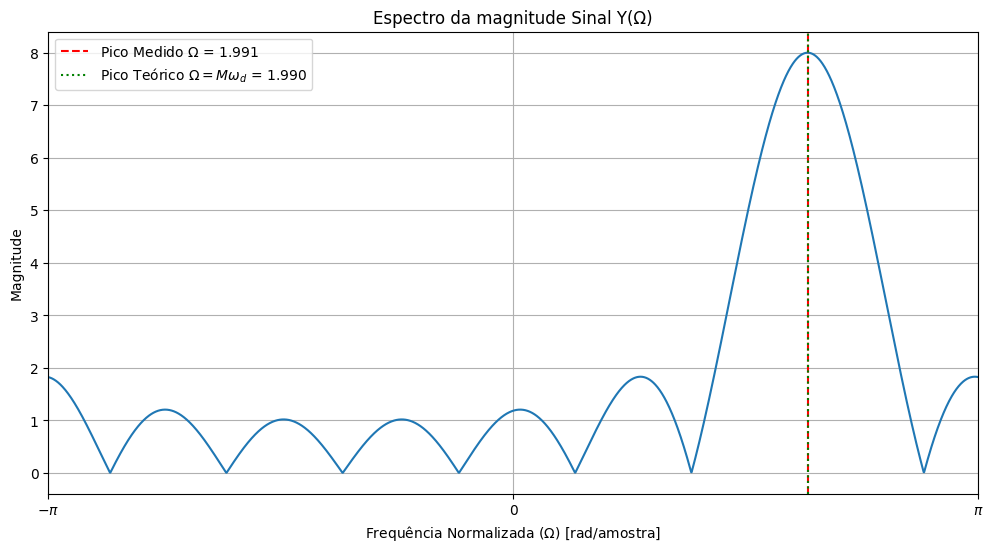

Shift Doppler original (ωd): 0.1047 rad/amostra
Shift 'Amplificado' Teórico (M*ωd): 1.9897 rad/amostra
Pico Medido no Espectro (Ω_pico): 1.9911 rad/amostra


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftshift

Y_spec = fftshift(fft(y_otimizado, 2048))
Y_mag = np.abs(Y_spec)

# Cria o eixo de frequência para o espectro de Y

freq_Omega = np.linspace(-np.pi, np.pi, 2048, endpoint=False)

# Encontra o pico medido
indice_pico = np.argmax(Y_mag)
Omega_pico_medido = freq_Omega[indice_pico]

Omega_pico_teorico = M * wd_real

plt.figure(figsize=(12, 6))
plt.plot(freq_Omega, Y_mag)
plt.title("Espectro da magnitude Sinal Y(Ω)")
plt.xlabel("Frequência Normalizada ($\Omega$) [rad/amostra]")
plt.ylabel("Magnitude")
plt.grid(True)
plt.axvline(Omega_pico_medido, color='r', linestyle='--', label=f'Pico Medido $\Omega$ = {Omega_pico_medido:.3f}')
plt.axvline(Omega_pico_teorico, color='g', linestyle=':', label=f'Pico Teórico $\Omega=M\omega_d$ = {Omega_pico_teorico:.3f}')
tick_locations = [-np.pi, 0, np.pi]
tick_labels = ['$-\pi$', '0', '$\pi$']
plt.xticks(tick_locations, tick_labels)
plt.xlim(-np.pi, np.pi)

plt.legend()
plt.show()

print(f"Shift Doppler original (ωd): {wd_real:.4f} rad/amostra")
print(f"Shift 'Amplificado' Teórico (M*ωd): {Omega_pico_teorico:.4f} rad/amostra")
print(f"Pico Medido no Espectro (Ω_pico): {Omega_pico_medido:.4f} rad/amostra")

# Simulação de Radar completo

## Sinal emitido

In [ ]:
#Parametros vistos no livro

T = 7*10**-6 #duração
W = 7*10**6 #largura de banda
TW = T*W #produto TW
fs = 8*10**6 #taxa de amostragem
p = W/fs
L = 11 #quantidade de pulsos

delta = 60*10**-6 #periodo de repeticao
fc = 7*10**9

#janela de recepção de 25us até 50us

#convertendo essa janela para distância em metros é tido
Dmin = 3750
Dmax = 7500

M = round(delta * fs) # M periodo entre pulsos, converte periodo entre pulsos segundos para periodo entre amostras M

#sinal chirp e filtro casado
p_lfm = dchirp(TW=TW, p=p)
h = match_filter(TW=TW, p=p)

atraso_max_amostras =  round(distancia_segundos(7500) * fs) #por conta da janela de observaçao O radar tem limite de distancia
tamanho_total = (L - 1) * M + len(p_lfm) + atraso_max_amostras #tamanho total do vetor de sinal retorno simulado

#esse esquema ajuda a entender o tamanho total

"""
|-----------(L-1)*M-----------|----N----|------atraso_max------|
^                             ^         ^                      ^
Início da                     Início do Fim da                 Chegada do último eco
transmissão                   último    transmissão            do alvo mais distante
                              pulso
"""

wave_burst = np.zeros(tamanho_total, dtype=np.complex128) #cria um array zerado com o tamanho total das rajadas
for l in range(L):
  start = l * M  #começa em l*(M) + o atraso
  end = start + len(p_lfm) #final do chirp
  if end < tamanho_total: # O sinal esta dentro da janela do radar
    wave_burst[start:end] = p_lfm #insere o chirp em um slice do array

## Visualização do sinal emitido

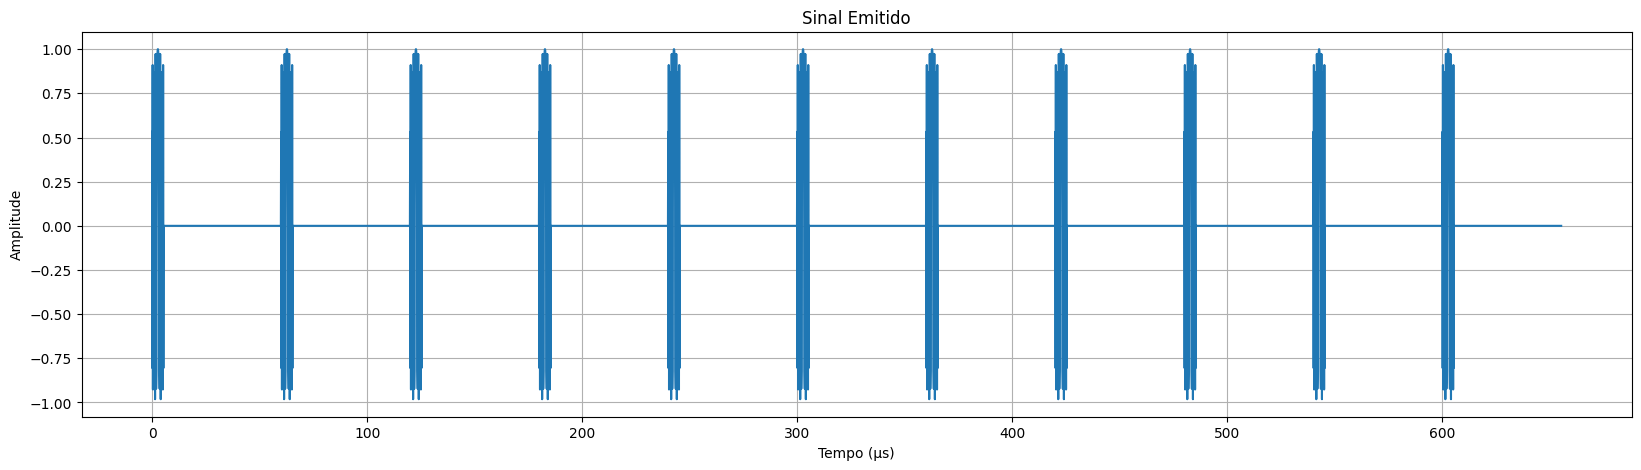

In [ ]:
tempo_total_seg = tamanho_total / fs
tempo_us = np.linspace(0, tempo_total_seg * 1e6, tamanho_total, endpoint=False)

plt.figure(figsize=(20, 5))
plt.plot(tempo_us, np.real(wave_burst))
plt.xlabel('Tempo (μs)')
plt.ylabel('Amplitude')
plt.title('Sinal Emitido')
plt.grid(True)
plt.show()

## Geração do sinal de retorno após detectar 3 objetos simulados

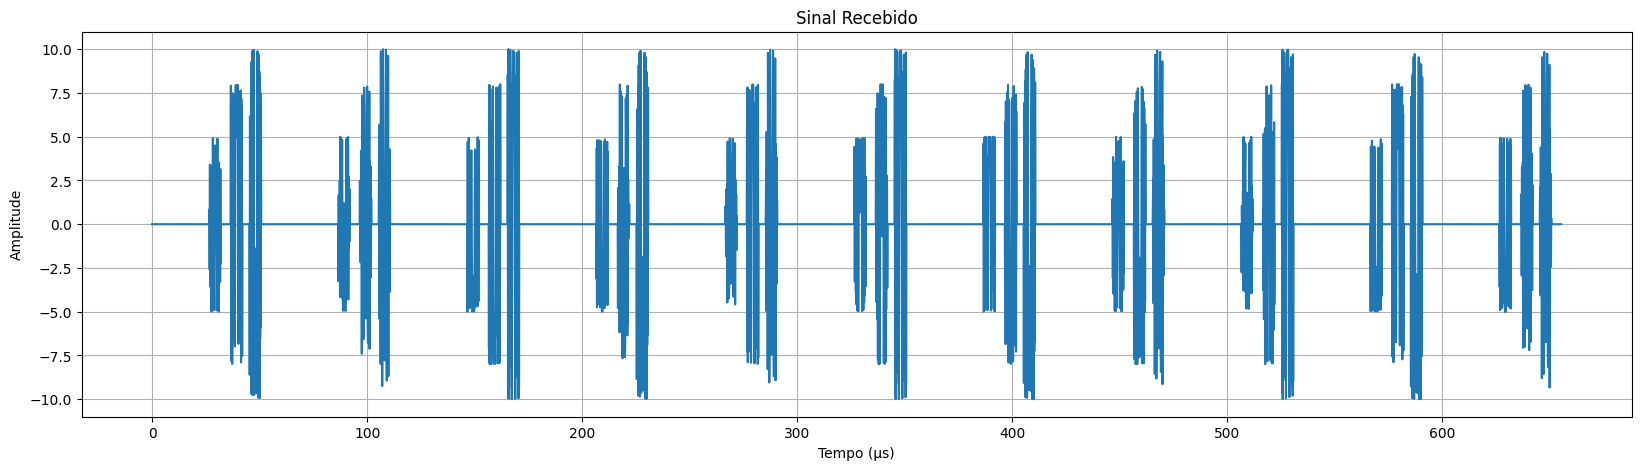

In [ ]:
# Gera 3 alvos arbitrarios
alvos = [
    {'distancia': 4000, 'velocidade': 50,  'amplitude': 5.0},
    {'distancia': 5500, 'velocidade': -80, 'amplitude': 8},
    {'distancia': 6800, 'velocidade': 120, 'amplitude': 10}
]

#Parametros
T = 7*10**-6 #duração
W = 7*10**6 #largura de banda
TW = T*W #produto TW
fs = 8*10**6 #taxa de amostragem
p = W/fs
L = 11

delta = 60*10**-6
fc = 7*10**9
#janela de recepção de 25us até 50us
Dmin = 3750
Dmax = 7500
M = round(delta * fs) # M periodo entre pulsos

p_lfm = dchirp(TW=TW, p=p)
h = match_filter(TW=TW, p=p)


atraso_max_amostras =  round(distancia_segundos(7500) * fs) #por conta da janela O radar tem limite de distancia
tamanho_total = (L - 1) * M + len(p_lfm) + atraso_max_amostras

"""
|-----------(L-1)*M-----------|----N----|------atraso_max------|
^                             ^         ^                      ^
Início da                     Início do Fim da                 Chegada do último eco
transmissão                   último    transmissão            do alvo mais distante
                              pulso
"""

sinal_recebido_final = np.zeros(tamanho_total, dtype=np.complex128)

for alvo in alvos:#cria o sinal rajada com delay para cada alvo


  distancia = alvo['distancia']
  velocidade = alvo['velocidade']
  amplitude = alvo['amplitude']

  #calcula o atraso e a frequência Doppler
  atraso_em_segundos = distancia_segundos(distancia)
  atraso_em_amostras = round(atraso_em_segundos * fs)
  fd = (2 * velocidade * fc) / (3e8)

  #cria o eco em rajadas
  eco_rajada_um_alvo = np.zeros(tamanho_total, dtype=np.complex128) #cria um array zerado com o tamanho total das rajadas
  for l in range(L):
    start = l * M + atraso_em_amostras #começa em l*(M) + o atraso
    end = start + len(p_lfm) #final do chirp
    if end < tamanho_total: # O sinal esta dentro da janela do radar
      eco_rajada_um_alvo[start:end] = p_lfm * amplitude #insere o chirp em um slice do array

  #aplicar o deslocamneto Doppler a esta rajada completa
  n_indices = np.arange(tamanho_total)
  doppler_phasor = np.exp(1j * 2 * np.pi * fd * (n_indices / fs))
  eco_final_alvo = eco_rajada_um_alvo * doppler_phasor

  # Soma o eco deste alvo ao sinal recebido total
  sinal_recebido_final += eco_final_alvo


tempo_total_seg = tamanho_total / fs #vetor de tempo
tempo_us = np.linspace(0, tempo_total_seg * 1e6, tamanho_total, endpoint=False)

plt.figure(figsize=(20, 5))
plt.plot(tempo_us, np.real(sinal_recebido_final))
plt.xlabel('Tempo (μs)')
plt.ylabel('Amplitude')
plt.title('Sinal Recebido')
plt.grid(True)
plt.show()

# Aplicação de ruido gaussiano

<function matplotlib.pyplot.show(close=None, block=None)>

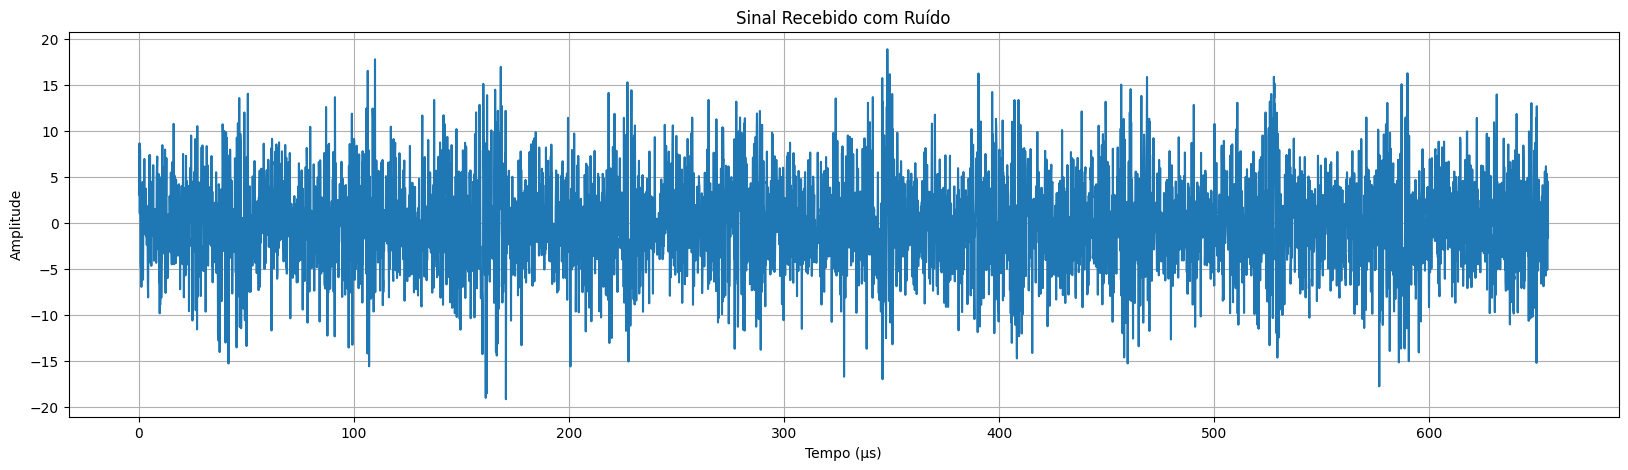

In [ ]:

sinal_com_ruido = adicionar_ruido_awgn(sinal_recebido_final, snr_db=-3)

plt.figure(figsize=(20, 5))
plt.plot(tempo_us, np.real(sinal_com_ruido))
plt.xlabel('Tempo (μs)')
plt.ylabel('Amplitude')
plt.title('Sinal Recebido com Ruído')
plt.grid(True)
plt.show

## Autocorrelação com o filtro casado

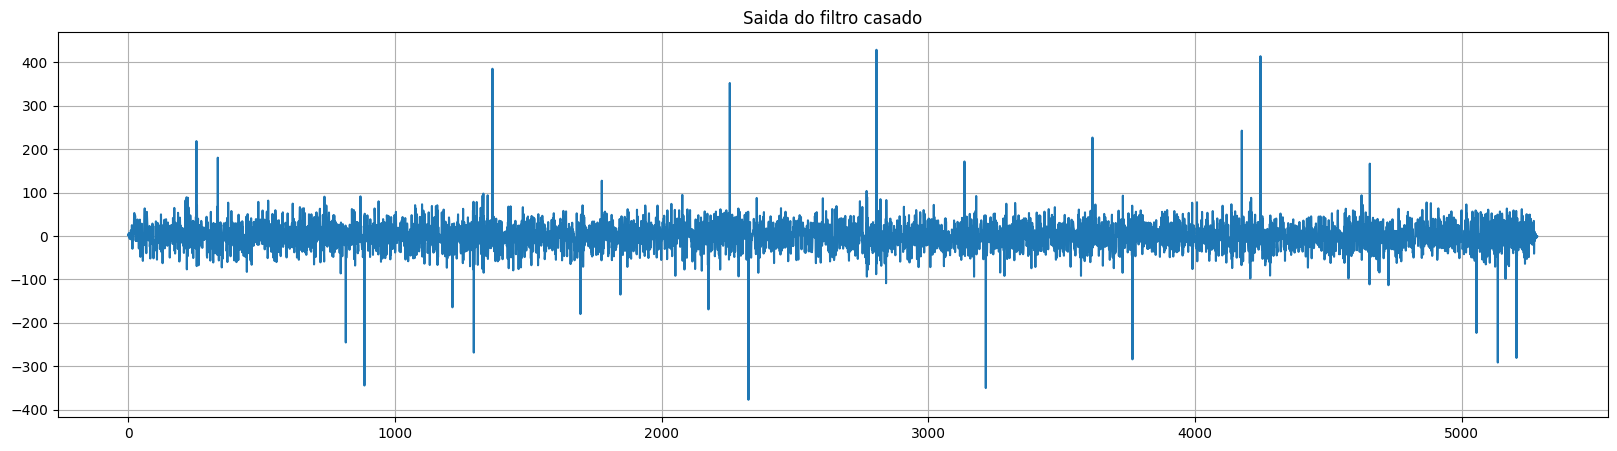

In [ ]:
y = np.convolve(sinal_com_ruido, h, mode='full')

plt.figure(figsize=(20, 5))
plt.title("Saida do filtro casado")
plt.plot(np.real(y))
plt.grid(True)

## Processamento do sinal de retorno

## matriz  Distância-Pulso

In [ ]:
N = len(p_lfm)
# Crie uma matriz vazia com : L linhas, M colunas
matriz_distancia_pulso = np.zeros((L, M), dtype=np.complex128)

# o deslocamento inicial o ponto zero
offset = N - 1

# loop para cada um dos L pulsos recebidos (linha da matriz)
for l in range(L):
    # define o início do segmento de 'y' que corresponde a este pulso
    start_y = l * M + offset

    # define o fim do segmento
    end_y = start_y + M
    if end_y <= len(y):
        matriz_distancia_pulso[l, :] = y[start_y:end_y] #insere o pulso na linha certa


## Detecção da distância

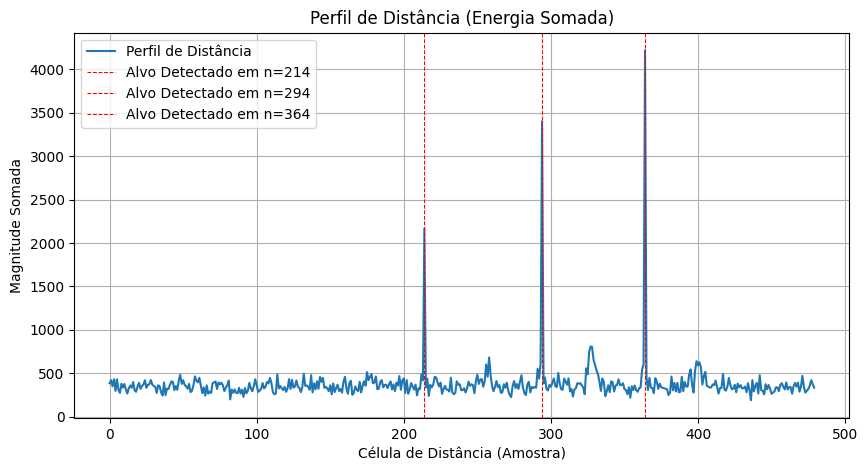

In [ ]:
perfil_distancia = np.sum(np.abs(matriz_distancia_pulso), axis=0) # soma todas as kinhas em um só vetor
indices_dos_alvos = pkpicker(perfil_distancia)

plt.figure(figsize=(10, 5))
plt.plot(perfil_distancia, label='Perfil de Distância')
plt.title("Perfil de Distância (Energia Somada)")
plt.xlabel("Célula de Distância (Amostra)")
plt.ylabel("Magnitude Somada")
plt.grid(True)

for pico in indices_dos_alvos:
    label_pico = f'Alvo Detectado em n={pico}'
    plt.axvline(x=pico, color='r', linestyle='--', label=label_pico, linewidth=0.75)

plt.legend()
plt.show()

In [ ]:
#DISTANCIA DETECTADA
indices_dos_alvos = pkpicker(perfil_distancia)
print(f"Alvos encontrados amostras de distância: {indices_dos_alvos}")
Distancia = ((np.array(indices_dos_alvos)/fs) * c/2)
Distancia

Alvos encontrados amostras de distância: [np.int64(214), np.int64(294), np.int64(364)]


array([4012.5, 5512.5, 6825. ])

## Detecção da velocidade

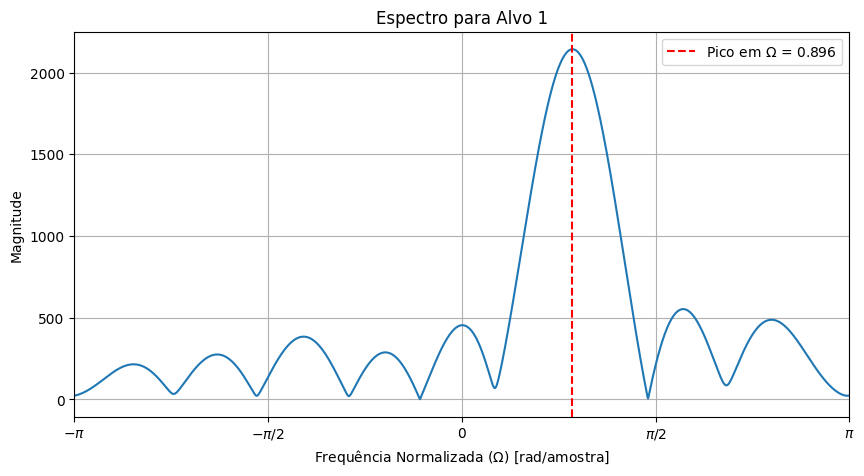

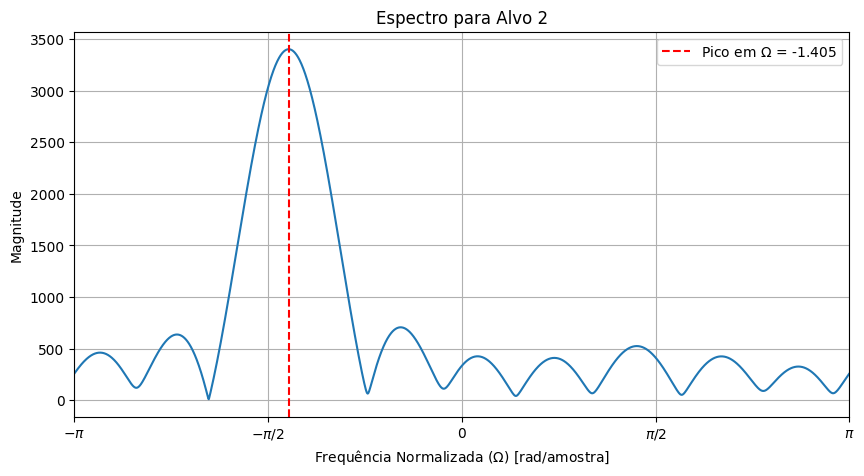

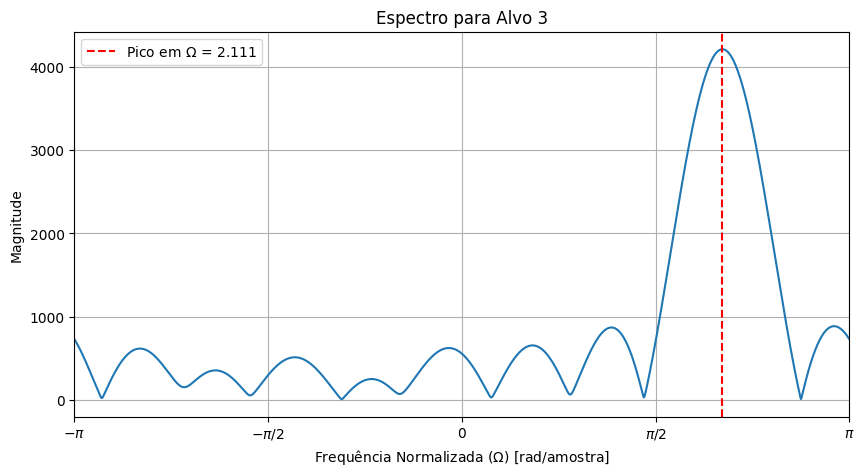

--- RESULTADOS DA DETECÇÃO ---
Alvo 1: Distância = 4012.50 m, Velocidade = 50.92 m/s
Alvo 2: Distância = 5512.50 m, Velocidade = -79.87 m/s
Alvo 3: Distância = 6825.00 m, Velocidade = 119.98 m/s


In [ ]:
resultados_finais = []

i = 1
for idx_alvo in indices_dos_alvos:

    dados_doppler_alvo = matriz_distancia_pulso[:, idx_alvo] #EXTRAI A COLUNA DA MATRIZ

    Y_doppler = fftshift(fft(dados_doppler_alvo, 2048)) # Calcula a fft
    freq_axis_doppler = np.linspace(-np.pi, np.pi, 2048, endpoint=False)
    indice_pico_doppler = np.argmax(np.abs(Y_doppler))
    Omega_pico = freq_axis_doppler[indice_pico_doppler]

    plt.figure(figsize=(10, 5))
    plt.plot(freq_axis_doppler, np.abs(Y_doppler))
    distancia_m_aprox = (idx_alvo / fs) * c / 2
    plt.title(f"Espectro para Alvo {i}")
    plt.xlabel("Frequência Normalizada ($\Omega$) [rad/amostra]")
    plt.ylabel("Magnitude")
    plt.grid(True)
    plt.axvline(Omega_pico, color='r', linestyle='--', label=f'Pico em $\Omega$ = {Omega_pico:.3f}')
    tick_locations = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
    tick_labels = ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$']
    plt.xticks(tick_locations, tick_labels)
    plt.xlim(-np.pi, np.pi)
    plt.legend()
    plt.show()

    wd = Omega_pico / M
    fd_calculado = (wd * fs) / (2 * np.pi)
    v_calculada = (fd_calculado * c) / (2 * fc)

    resultados_finais.append({'distancia': distancia_m_aprox, 'velocidade': v_calculada})
    i += 1

print("--- RESULTADOS DA DETECÇÃO ---")
for i, res in enumerate(resultados_finais):
    print(f"Alvo {i+1}: Distância = {res['distancia']:.2f} m, Velocidade = {res['velocidade']:.2f} m/s")